# De spectrometer

## Import packages

In [1]:
import numpy as np
import sympy as sp
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import math
import scipy.optimize as opt

sp.init_printing()

In [2]:
# interactieve plots in jupyter lab - niet runnen als je de extensie niet hebt!
#%matplotlib widget

## hulpfuncties

In [3]:
def DMS_to_rad(dd, mm, ss=0):
    degrees = dd + mm/60 + ss/3600
    return np.radians(degrees)

def error(function, variables, deviations):
    return sp.sqrt(sum([sp.diff(function, variables[i])**2 * deviations[i]**2 for i in range(len(variables))]))


## Analoge spectrometer

### Voorbereidende opgaves

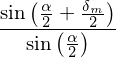

In [4]:
# variabelen voor functie
lam, delta, alfa = sp.symbols('lambda, delta_m, alpha')
# standaardafwijkingen op deze variabelen
dlam, ddelta, dalfa = sp.symbols('S_lambda, S_delta, S_alpha')
# functie die brekingsindex geeft in functie dispersie en opening
n = sp.sin((delta + alfa)/2)/sp.sin(alfa/2)
display(n)

In [5]:
# gegeven waardes voor de hoeken
ALFA = DMS_to_rad(60, 18, 0)
S_ALFA = DMS_to_rad(0, 10, 0)/np.sqrt(3)
DELTA = DMS_to_rad(35, 46, 0)
S_DELTA = DMS_to_rad(0, 20, 0)/np.sqrt(3)
# bereken de waarde van n:
N = n.subs({alfa : ALFA, delta : DELTA})
display(N)
# bereken de fout op N
dn = error(n, [alfa, delta], [dalfa, ddelta])
DN = dn.subs({alfa : ALFA, delta : DELTA, dalfa : S_ALFA, ddelta : S_DELTA})
display(DN)

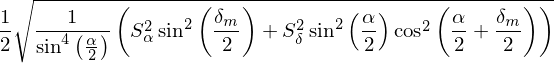

In [6]:
display(sp.simplify(dn))

### Heliumbron

**Data bron**

In [7]:
nulhoek = np.array([-1, -27])
lijn1 = np.array([[46, 0]]) - nulhoek
lijn2 = np.array([[46, 16], [46, 9], [46, 9]]) - nulhoek
lijn3 = np.array([[46, 40], [46, 34], [46, 34]]) - nulhoek
lijn4 = np.array([[47, 45]]) - nulhoek
lijn5 = np.array([[47, 46], [47, 47], [47, 45]]) - nulhoek
lijn6 = np.array([[47, 54]]) - nulhoek
lijn7 = np.array([[48, 17], [48, 16], [48, 16]]) - nulhoek
lijn8 = np.array([[48, 41], [48, 44], [48, 43]]) - nulhoek

In [8]:
lijnen = [lijn1, lijn2, lijn3, lijn4, lijn5, lijn6, lijn7, lijn8]
rad = [DMS_to_rad(lijn[:,0], lijn[:,1]) for lijn in lijnen]
mean = np.array([radialen.mean() for radialen in rad])
stdv = np.array([radialen.std() for radialen in rad])
# golflengtes gegeven
LAMBDA = np.array([706.5, 667.8, 587.5, 504.8, 501.6, 492.1, 471.3, 447.1])

In [9]:
colors = ["#f10000", "#ff0000", "#ffdf00", "#00ff3f", "#00ff66", "#00ffe5", "#009eff", "#0023ff"]

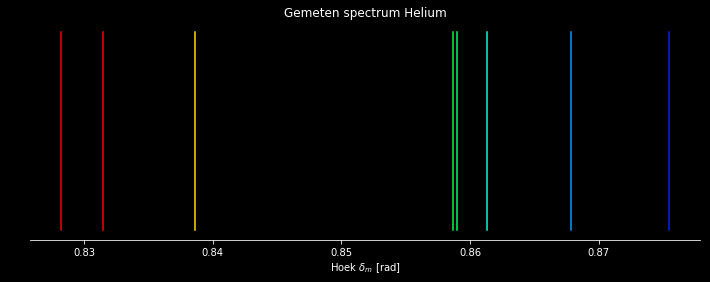

In [10]:
# plot van het gemeten spectrum
fig, ax = plt.subplots(1,1,figsize=(12,4))

for i in range(8):
    angle = mean[i]
    ax.plot([angle, angle], [0, 1], color=colors[i])

ax.set_facecolor("k")
fig.set_facecolor("k")
ax.tick_params(axis='x', color='w', labelcolor='w')
ax.spines['bottom'].set_color('w')
ax.set_xlabel('Hoek $\delta_m$ [rad]')
ax.xaxis.label.set_color('w')
plt.title('Gemeten spectrum Helium', color='w')
plt.show()

fig.savefig("spectrum Helium.png", facecolor='k', dpi=300)

In [11]:
# openingshoek prisma
ALPHA = DMS_to_rad(60, 0)
# bereken de n-waardes
n_num = sp.lambdify([delta, alfa], n, "numpy")(mean, ALPHA*np.ones_like(mean))

**Bereken de fouten op de gemeten hoeken**

In [12]:
sys_fout = DMS_to_rad(0, 3)/np.sqrt(3)*np.sqrt(2)
errors = np.array([max(sys_fout/np.sqrt(len(lijnen[i])), stdv[i]) for i in range(8)])
# bereken de fouten op n
S_n = sp.lambdify([alfa, delta, dalfa, ddelta], dn, "numpy")(ALPHA*np.ones_like(mean), mean, errors, np.zeros_like(mean))

**Fit de rechte door de data**

In [13]:
# de te fitten functie
def Cauchy(lam, B, C):
    return C + B/lam**2

In [14]:
# vind de fitparameters
fit = opt.curve_fit(Cauchy, LAMBDA, n_num, (0, 100))

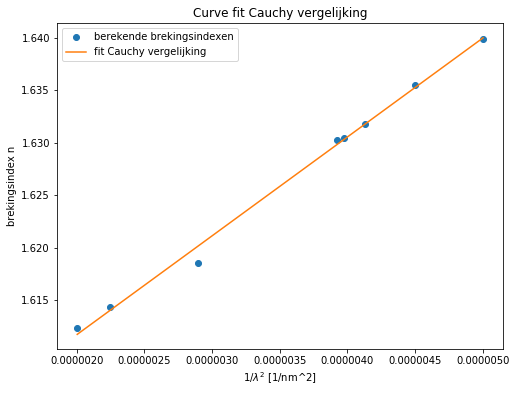

In [15]:
fig, ax = plt.subplots(1,1,figsize=(8, 6))

X = np.linspace(LAMBDA.min(), LAMBDA.max(), 1000)
ax.plot(1/LAMBDA**2, n_num, 'o', label="berekende brekingsindexen")
ax.plot(1/X**2, Cauchy(X, *fit[0]), label="fit Cauchy vergelijking")
ax.set_ylabel("brekingsindex n")
ax.set_xlabel("$1/\lambda^2$ [1/nm^2]")

plt.title("Curve fit Cauchy vergelijking")
plt.legend()

plt.show()

fig.savefig("Fit Cauchyvergelijking.png", dpi=300)

**Print de fitparameters**

In [16]:
print("B: %.0f +- %.0f \n C: %.4f +- %.4f" %(fit[0][0], np.sqrt(fit[1][0,0]), fit[0][1], np.sqrt(fit[1][1,1])))

B: 9416 +- 262 
 C: 1.5929 +- 0.0010


### Onbekende bron

**Data bron**

In [17]:
lijn1 = np.array([[46, 51], [46, 51], [46, 49], [46, 49]]) - nulhoek
lijn2 = np.array([[47, 12], [47, 7], [47, 11], [47, 9]]) - nulhoek
lijn3 = np.array([[48, 57], [48, 58], [48, 59], [48, 59]]) - nulhoek

In [18]:
lijnen = [lijn1, lijn2, lijn3]
rad = [DMS_to_rad(lijn[:,0], lijn[:,1]) for lijn in lijnen]
mean = np.array([radialen.mean() for radialen in rad])
stdv = np.array([radialen.std() for radialen in rad])

**Omrekenen graden naar golflengtes**

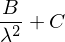

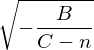

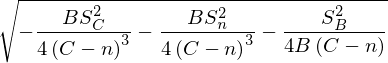

In [19]:
# definieer de Cauchy vergelijking als sympy functie
B, C, n_sym, S_B, S_C, S_n_sym = sp.symbols('B, C, n, S_B, S_C, S_n')
cauchy = B/lam**2 + C
display(cauchy)
# inverteer cauchy naar golflengte = ...
cauchy_inv = sp.solve(sp.Eq(cauchy, n_sym), lam)[1]
display(cauchy_inv)
# bereken de foutenpropagatieformule op cauchy_inv
sym = [B, C, n_sym]
S_sym = [S_B, S_C, S_n_sym]
S_lam = error(cauchy_inv, sym, S_sym)
display(S_lam)

In [20]:
# bereken n uit de gemeten hoeken en de fout op n
n_num = sp.lambdify([delta, alfa], n, "numpy")(mean, ALPHA*np.ones_like(mean))
# bereken de fout op elke hoek, rekening houdend met de systematische fout
sys_fout = DMS_to_rad(0, 3)/np.sqrt(3)*np.sqrt(2)
errors = np.array([max(sys_fout/np.sqrt(len(lijnen[i])), stdv[i]) for i in range(3)])
# bereken de fouten op n
S_n = sp.lambdify([alfa, delta, dalfa, ddelta], dn, "numpy")(ALPHA*np.ones_like(mean), mean, errors, np.zeros_like(mean))

In [21]:
# bereken uit de brekingsindexen  de golflengtes
B_num, C_num = (fit[0][0], fit[0][1])
S_B_num, S_C_num = np.sqrt(np.array([fit[1][0,0], fit[1][1,1]]))
LAMBDA = sp.lambdify(sym, cauchy_inv, "numpy")(B_num*np.ones_like(n_num), C_num*np.ones_like(n_num), n_num)
S_LAMBDA = sp.lambdify(sym + S_sym, S_lam, "numpy")(B_num*np.ones_like(n_num), C_num*np.ones_like(n_num), n_num, S_B_num*np.ones_like(n_num), S_C_num*np.ones_like(n_num), S_n)

In [22]:
display(LAMBDA, S_LAMBDA)

array([579.41978399, 547.56104395, 435.63239118])

array([13.23953245, 12.090776  ,  7.5325213 ])

**Importeer spectrum van kwik**

In [23]:
spectrum = pd.read_csv("mercury.txt", sep="   ", names=["wavelength", "intensity"])
spectrum = spectrum.loc[spectrum['intensity'] >= 1100]
spectrum["wavelength"] = spectrum["wavelength"]/10
spectrum

C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.


,wavelength,intensity
0,404.656,1800
5,435.833,2000
22,546.074,1100
25,576.960,1240
26,578.966,1100


In [24]:
# selecteer enkel de lijnen die ik ook zag
spectrum = spectrum.loc[[5, 22, 26]]
spectrum

,wavelength,intensity
5,435.833,2000
22,546.074,1100
26,578.966,1100


**Maak een plot van het gemeten spectrum van kwik**

In [25]:
colors=["#fcff00", "#9cff00", "#1d00ff"]
width = [4, 1.5, 1.5]

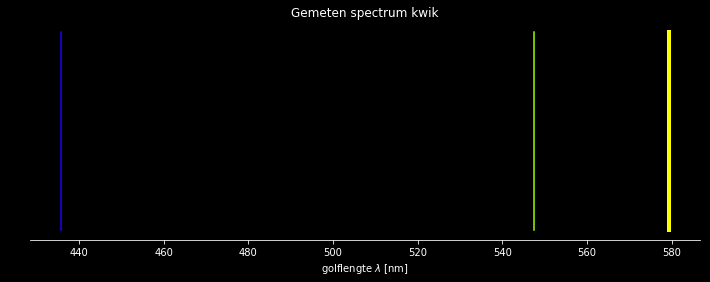

In [26]:
# plot van het gemeten spectrum
fig, ax = plt.subplots(1,1,figsize=(12,4))

for i in range(3):
    length = LAMBDA[i]
    ax.plot([length, length], [0, 1], color=colors[i], linewidth=width[i])
    length = spectrum["wavelength"].values[2-i]
    #ax.plot([length, length], [1, 2], color=colors[i], linewidth=width[i])

ax.set_facecolor("k")
fig.set_facecolor("k")
ax.tick_params(axis='x', color='w', labelcolor='w')
ax.spines['bottom'].set_color('w')
ax.set_xlabel('golflengte $\lambda$ [nm]')
ax.xaxis.label.set_color('w')
plt.title('Gemeten spectrum kwik', color='w')
plt.show()

fig.savefig("spectrum kwik.png", facecolor='k', dpi=300)